# General about GMM

A Gaussian Mixture Model is a probabilistic model that represents the distribution of a dataset as a combination of several Gaussian distributions, each representing a sub-population or component of the data.

In a GMM, each Gaussian distribution is characterized by its mean and covariance matrix. The parameters of the model are estimated from the data using the Expectation-Maximization (EM) algorithm. The EM algorithm iteratively estimates the parameters of the Gaussians and assigns each data point to the Gaussian component that maximizes its posterior probability.

GMMs are widely used in various fields, such as image and speech processing, clustering, and anomaly detection, among others. They are particularly useful when the data is complex and multi-modal, i.e., it can be represented by a linear combination of multiple gaussian distributions.

## Import 10 images to compare

these 10 images are uploaded to Github already.https://github.com/Zoe1999Wang/Matterhorn-Studio-DM-project/tree/main

In [1]:
import glob
import PIL
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from PIL import Image
from scipy import optimize
from sklearn.metrics import r2_score
import pandas as pd
from matplotlib.patches import Rectangle
from pylab import gray, imshow, show
import cv2
import imutils
import laserbeamsize as lbs

image_list = glob.glob(r'/home/zw3721/Downloads/2022_master_project/compare images/*.png')

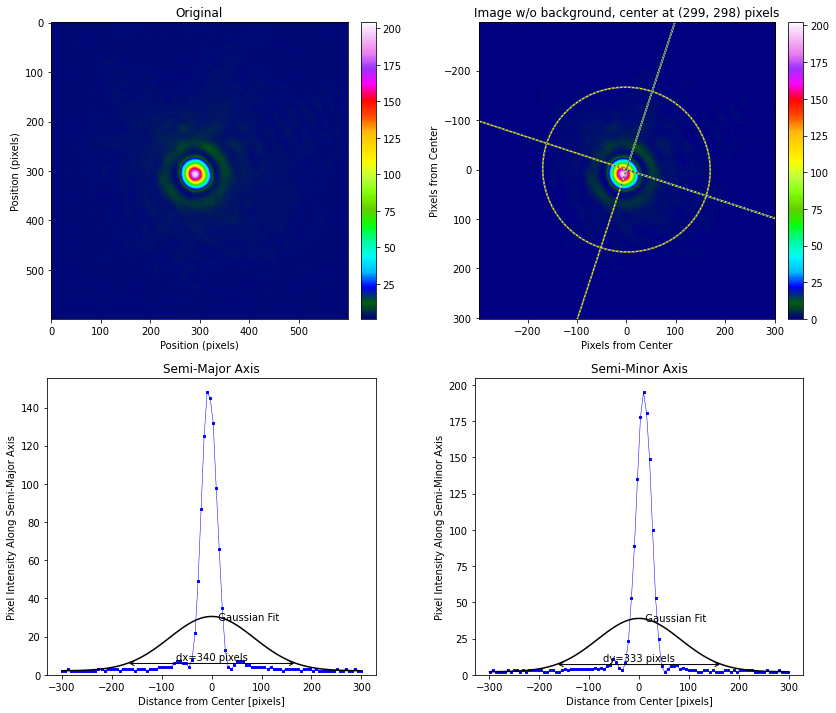

0.9797441285368962
0.14232312343081785


In [2]:
img=cv2.imread(image_list[9])#change the number to see different images, from bad to good by intuition.
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
beam=gray
x, y, dx, dy, phi = lbs.beam_size(beam)
lbs.beam_size_plot(beam)
plt.show()
x, y, dx, dy, phi = lbs.beam_size(beam)
Ellipticity=min(dx,dy)/max(dx,dy)
Eccentricity=np.sqrt(1-Ellipticity)
print(Ellipticity)
print(Eccentricity)

## Potential procedure

Convert the image into a 1D array by either selecting a line through the center of the focal spot or by averaging the image along one axis.

preprocessing? remove noise and enhance contrast(how?)

Normalise the 1D array to have a mean of 0 and a standard deviation of 1.

Fit a GMM to the 1D array with a suitable number of Gaussian components. The number of components can be determined using statistical techniques such as Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC).(more info about the choice of number of components later)

Once the GMM is fitted, identify the Gaussian component that corresponds to the central part of the focal spot. This can be done by selecting the component with the highest weight or by identifying the component with the mean closest to 0.

Calculate the standard deviation of the selected Gaussian component.Use the standard deviation as a measure of the spot size, with smaller values indicating better focal spot quality. or the log-likelihood, the larger the better. (need to discuss here)

## Choosing the number of Gaussian components

Choosing the number of Gaussian components for a Gaussian Mixture Model (GMM) is an important step in the analysis of focal spots. A suitable number of components is necessary to accurately represent the distribution of the data, while avoiding overfitting.

Some common methods for choosing the number of Gaussian components in a GMM:

**Akaike Information Criterion (AIC)**: AIC is a measure of the relative quality of a statistical model for a given set of data. AIC balances the goodness of fit of the model with the complexity of the model. AIC estimates the quality of each model by balancing the fit of the model to the data with the number of parameters used. In general, a lower AIC score indicates a better model fit. The AIC score is calculated as -2loglikelihood + 2p, where loglikelihood is the log-likelihood of the data given the model and p is the number of parameters in the model. A lower AIC score indicates a better model. Therefore, we can try fitting GMMs with different numbers of components and choose the number that minimizes the AIC score.

**Bayesian Information Criterion (BIC)**: BIC is another measure of the relative quality of a statistical model for a given set of data. BIC is similar to AIC, but it penalizes model complexity more heavily. The BIC score is calculated as -2loglikelihood + log(N)p, where N is the number of data points and p is the number of parameters in the model. To choose the number of Gaussian components using BIC, we can fit multiple GMMs with different numbers of components, and select the model with the lowest BIC value.

**Cross-validation**: We can use cross-validation techniques, such as k-fold cross-validation or leave-one-out cross-validation, to estimate the quality of the model with different numbers of components. We can then choose the number of components that results in the best cross-validation performance.

**Visual inspection**: We can plot the likelihood or density function of the GMM for different numbers of components and visually inspect the plot to see if it captures the characteristics of the data well. We can choose the number of components that results in a good balance between model complexity and the ability to capture the underlying distribution of the data.

### GMM with AIC

In [3]:
import numpy as np
from sklearn.mixture import GaussianMixture
score_x = []
score_y = []
for i in range (len(image_list)):
    img = Image.open(image_list[i])
    focal_spot_img = img
    # Convert image into 1D array
    focal_spot_array = np.mean(focal_spot_img, axis=1) # Take the mean along rows
    # Normalise the 1D array
    focal_spot_array = (focal_spot_array - np.mean(focal_spot_array)) / np.std(focal_spot_array)
    # Choose number of components using AIC
    lowest_aic = np.inf
    best_gmm = None
    for n in range(1, 11): # Try different number of components
        gmm = GaussianMixture(n_components=n).fit(focal_spot_array.reshape(-1, 1))
        aic = gmm.aic(focal_spot_array.reshape(-1, 1))
        if aic < lowest_aic:
            lowest_aic = aic
            best_gmm = gmm
    # Fit the best GMM
    best_gmm.fit(focal_spot_array.reshape(-1, 1))
    # Identify the Gaussian component corresponding to the central part of the focal spot
    central_component_idx = np.argmax(best_gmm.weights_) # Select the component with the highest weight
    central_component = best_gmm.means_[central_component_idx]
    central_component_std = np.sqrt(best_gmm.covariances_[central_component_idx])
    # Calculate quality number
    quality_number_x = central_component_std
    score_x.append(quality_number_x)
for i in range (len(image_list)):
    img = Image.open(image_list[i])
    focal_spot_array = np.mean(focal_spot_img, axis=0) # Take the mean along columns
    focal_spot_array = (focal_spot_array - np.mean(focal_spot_array)) / np.std(focal_spot_array)
    lowest_aic = np.inf
    best_gmm = None
    for n in range(1, 11):
        gmm = GaussianMixture(n_components=n).fit(focal_spot_array.reshape(-1, 1))
        aic = gmm.aic(focal_spot_array.reshape(-1, 1))
        if aic < lowest_aic:
            lowest_aic = aic
            best_gmm = gmm
    best_gmm.fit(focal_spot_array.reshape(-1, 1))
    central_component_idx = np.argmax(best_gmm.weights_) 
    central_component = best_gmm.means_[central_component_idx]
    central_component_std = np.sqrt(best_gmm.covariances_[central_component_idx])
    quality_number_y = central_component_std
    score_y.append(quality_number_y)
    

In [4]:
print(score_y)
print(score_x)

[array([[0.05058128]]), array([[0.05037284]]), array([[0.03503029]]), array([[0.03438534]]), array([[0.04040519]]), array([[0.03856606]]), array([[0.03917264]]), array([[0.02977204]]), array([[0.06510599]]), array([[0.03038222]])]
[array([[0.05564117]]), array([[0.04401742]]), array([[0.04648034]]), array([[0.09222798]]), array([[0.06791662]]), array([[0.05509131]]), array([[0.05437049]]), array([[0.06785377]]), array([[0.06593568]]), array([[0.04572466]])]


[[[0.0028144 ]]

 [[0.00221728]]

 [[0.00162822]]

 [[0.00317129]]

 [[0.00274418]]

 [[0.00212465]]

 [[0.00212984]]

 [[0.00202014]]

 [[0.00429281]]

 [[0.00138922]]]


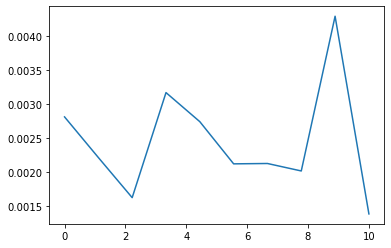

In [5]:
score=np.multiply(score_x, score_y) 
print(score)
y=np.reshape(score,10)
x=np.linspace(0,10,10)
plt.plot(x,y)

### GMM with BIC

In [6]:
score_x = []
score_y = []
for i in range (len(image_list)):
    # Convert image into 1D array
    img = Image.open(image_list[i])
    focal_spot_img = img
    focal_spot_array = np.mean(focal_spot_img, axis=0) 

    # Normalize the 1D array
    focal_spot_array = (focal_spot_array - np.mean(focal_spot_array)) / np.std(focal_spot_array)

    # Fit GMM with optimal number of components
    optimal_n_components = 10 # Choose optimal number of components here
    gmm = GaussianMixture(n_components=optimal_n_components).fit(focal_spot_array.reshape(-1, 1))

    # Calculate log-likelihood of the image data under the fitted GMM
    log_likelihood_x = gmm.score_samples(focal_spot_array.reshape(-1, 1)).sum()
    score_x.append(log_likelihood_x)
for i in range (len(image_list)):
    # Convert image into 1D array
    img = Image.open(image_list[i])
    focal_spot_img = img
    focal_spot_array = np.mean(focal_spot_img, axis=1) 

    # Normalize the 1D array
    focal_spot_array = (focal_spot_array - np.mean(focal_spot_array)) / np.std(focal_spot_array)

    # Fit GMM with optimal number of components
    optimal_n_components = 10 # Choose optimal number of components here
    gmm = GaussianMixture(n_components=optimal_n_components).fit(focal_spot_array.reshape(-1, 1))

    # Calculate log-likelihood of the image data under the fitted GMM
    log_likelihood_y = gmm.score_samples(focal_spot_array.reshape(-1, 1)).sum()
    score_y.append(log_likelihood_y)

In [7]:
score=np.add(score_x, score_y) 
print(score)

[-1860.50151423 -1001.08604373   203.09474157 -2568.17142026
  -410.62268652 -2627.40617132 -2065.37952257  -224.76730287
  -190.54568332   379.32748481]


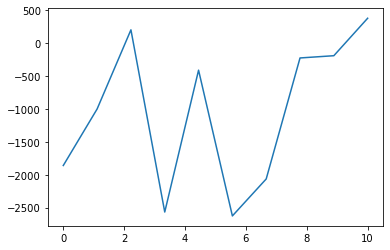

In [8]:
y=score
x=np.linspace(0,10,10)
plt.plot(x,y)

Comments: very first try on GMM, the quantity which can be regarded as quality number or how to determine the single number better is to be further discussed.

### Stability test for GMM with AIC

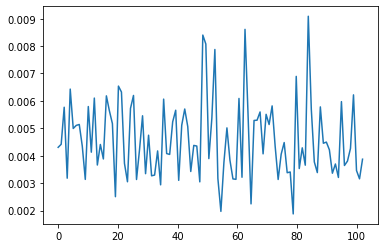

In [9]:
image_list1 = glob.glob(r'/home/zw3721/Downloads/2022_master_project/M3/*.png')

import numpy as np
from sklearn.mixture import GaussianMixture
score_x = []
score_y = []
for i in range (len(image_list1)):
    img = Image.open(image_list1[i])
    focal_spot_img = img
    # Convert image into 1D array
    focal_spot_array = np.mean(focal_spot_img, axis=1) # Take the mean along rows
    # Normalise the 1D array
    focal_spot_array = (focal_spot_array - np.mean(focal_spot_array)) / np.std(focal_spot_array)
    # Choose number of components using AIC
    lowest_aic = np.inf
    best_gmm = None
    for n in range(1, 11): # Try different number of components
        gmm = GaussianMixture(n_components=n).fit(focal_spot_array.reshape(-1, 1))
        aic = gmm.aic(focal_spot_array.reshape(-1, 1))
        if aic < lowest_aic:
            lowest_aic = aic
            best_gmm = gmm
    # Fit the best GMM
    best_gmm.fit(focal_spot_array.reshape(-1, 1))
    # Identify the Gaussian component corresponding to the central part of the focal spot
    central_component_idx = np.argmax(best_gmm.weights_) # Select the component with the highest weight
    central_component = best_gmm.means_[central_component_idx]
    central_component_std = np.sqrt(best_gmm.covariances_[central_component_idx])
    # Calculate quality number
    quality_number_x = central_component_std
    score_x.append(quality_number_x)
for i in range (len(image_list1)):
    img = Image.open(image_list1[i])
    focal_spot_array = np.mean(focal_spot_img, axis=0) # Take the mean along columns
    focal_spot_array = (focal_spot_array - np.mean(focal_spot_array)) / np.std(focal_spot_array)
    lowest_aic = np.inf
    best_gmm = None
    for n in range(1, 11):
        gmm = GaussianMixture(n_components=n).fit(focal_spot_array.reshape(-1, 1))
        aic = gmm.aic(focal_spot_array.reshape(-1, 1))
        if aic < lowest_aic:
            lowest_aic = aic
            best_gmm = gmm
    best_gmm.fit(focal_spot_array.reshape(-1, 1))
    central_component_idx = np.argmax(best_gmm.weights_) 
    central_component = best_gmm.means_[central_component_idx]
    central_component_std = np.sqrt(best_gmm.covariances_[central_component_idx])
    quality_number_y = central_component_std
    score_y.append(quality_number_y)

score=np.multiply(score_x, score_y) 
y=np.reshape(score,102)
x=np.linspace(0,102,102)
plt.plot(x,y)

### Stability test for GMM with BIC

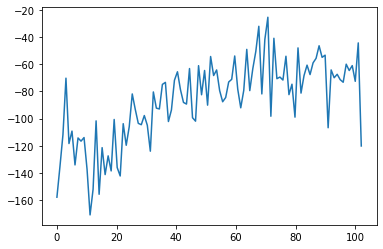

In [10]:
score_x = []
score_y = []
for i in range (len(image_list1)):
    # Convert image into 1D array
    img = Image.open(image_list1[i])
    focal_spot_img = img
    focal_spot_array = np.mean(focal_spot_img, axis=0) 

    # Normalize the 1D array
    focal_spot_array = (focal_spot_array - np.mean(focal_spot_array)) / np.std(focal_spot_array)

    # Fit GMM with optimal number of components
    optimal_n_components = 10 # Choose optimal number of components here
    gmm = GaussianMixture(n_components=optimal_n_components).fit(focal_spot_array.reshape(-1, 1))

    # Calculate log-likelihood of the image data under the fitted GMM
    log_likelihood_x = gmm.score_samples(focal_spot_array.reshape(-1, 1)).sum()
    score_x.append(log_likelihood_x)
for i in range (len(image_list1)):
    # Convert image into 1D array
    img = Image.open(image_list1[i])
    focal_spot_img = img
    focal_spot_array = np.mean(focal_spot_img, axis=1) 

    # Normalize the 1D array
    focal_spot_array = (focal_spot_array - np.mean(focal_spot_array)) / np.std(focal_spot_array)

    # Fit GMM with optimal number of components
    optimal_n_components = 10 # Choose optimal number of components here
    gmm = GaussianMixture(n_components=optimal_n_components).fit(focal_spot_array.reshape(-1, 1))

    # Calculate log-likelihood of the image data under the fitted GMM
    log_likelihood_y = gmm.score_samples(focal_spot_array.reshape(-1, 1)).sum()
    score_y.append(log_likelihood_y)
score=np.add(score_x, score_y) 
y=score
x=np.linspace(0,102,102)
plt.plot(x,y)

### reference

https://scikit-learn.org/stable/modules/mixture.html#variational-bayesian-gaussian-mixture

Burnham, K. P., & Anderson, D. R. (2004). Multimodel inference: understanding AIC and BIC in model selection. Sociological methods & research, 33(2), 261-304.